# Dataset level analysis

This notebook analyses dataset-level data from `rpackage_stats.csv`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd
import re

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

In [2]:
df = pd.read_csv("data/rpackage_stats.csv", delimiter='\t', \
                 names=["doi", "list_of_all", "comments_no", "dependen_no", "list_of_libs", "total_size"])
# doi, list_of_all_files, total_number_of_comments, total_numebr_of_libraries, list_of_libraries, total_size

In [3]:
len(df)

2091

In [4]:
df.head()

,doi,list_of_all,comments_no,dependen_no,list_of_libs,total_size
0,doi:10.7910/DVN/XFQZI2,FigureA2data.dta;Readme.rtf;Condemnation.dta;C...,71,10,rms;xtable;readstata13;Matching;foreign,411332
1,doi:10.7910/DVN/WGPDBS,campaign_effects_replication.do;replication_da...,17,1,ggplot2,12105318
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R;tab_8_campai...,194,111,ggplot2;lm_2008;lm_2004;character.only=TRUE;li...,2959665
3,doi:10.7910/DVN/ZWAGXZ,sponsorship_1_v3_November+6%2C+2017_12.32.csv;...,168,21,sylcount;sandwich;tidyverse;RCurl;acs;RJSONIO;...,5350420
4,doi:10.7910/DVN/JXXNDO,wgi_CoC_2013.csv;DB14-Distance-to-Frontier-dat...,140,0,NaN,1402185


# Convert file size to MB

In [5]:
df['sizeMB']=df['total_size']/1000000
df['sizeMB']=df['sizeMB'].round(2)

# Find number of files per dataset

In [6]:
def count_files_no(el):
    temp = el.split(";")
    return len(temp)

df['files_count']=df["list_of_all"].apply(count_files_no)

# Check if files contain readme or instructions

In [7]:
def contain_docs(el):
    temp = el.lower()
    temp = temp.replace(" ", "")
    temp = temp.replace("-", "")
    temp = temp.replace("_", "")
    
    if ('readme' in temp) or ('read.me' in temp): # avoid things like 'readdata'
        return 1
    if "codebook" in temp: # dataverse lingo
        return 1
    if 'instruction' in temp:
        return 1
    if "documentation" in temp or ('replicationdocument' in temp): 
        return 1
    if '.md' in temp:
        return 1
    if 'guide' in temp:
        return 1
    return 0

# doc and docs give many false positives
# many code files contain word replication, ie replication.r and replication.do
# extenstions: pdf, aux, tex, rtf, log, blg, doc
df['docs']=df["list_of_all"].apply(contain_docs)

In [8]:
df['docs'].value_counts()

1    1205
0     886
Name: docs, dtype: int64

# R file count

In [9]:
def contain_r_file(el):
    temp = el.lower()
    count = 0
    count += len(re.findall(r'\.r;', temp))
    if temp.endswith('.r'):
        count += 1
    return count

df['r_file']=df["list_of_all"].apply(contain_r_file)

# Check if there is a testing script

In [10]:
def contain_testing(el):
    temp = el.lower()
    if "test" in temp:
        return 1
    return 0

df['test']=df["list_of_all"].apply(contain_testing)

# Check if there is a testing library

In [11]:
df['list_of_libs']=df['list_of_libs'].fillna("")
df['list_of_libs'].isnull().sum()

0

In [12]:
def contain_testing_lib(el):
    if el is None:
        return 0
    temp = el.lower()
    if "runit" in temp:
        return 1
    if "testthat" in temp:
        return 1
    if "tinytest" in temp:
        return 1
    if "unitizer" in temp:
        return 1
    return 0

df['test_lib']=df["list_of_libs"].apply(contain_testing_lib)

In [13]:
df.test_lib.value_counts()

0    2091
Name: test_lib, dtype: int64

# Prov library

In [14]:
def contain_prov_lib(el):
    if el is None:
        return 0
    temp = el
    if "provR" in temp:
        return 1
    if "provenance" in temp:
        return 1
    if "RDTlite" in temp:
        return 1
    if "RDataTracker" in temp:
        return 1
    if "provTraceR" in temp:
        return 1
    return 0

df['prov']=df["list_of_libs"].apply(contain_prov_lib)

In [15]:
df['prov'].value_counts()

0    2091
Name: prov, dtype: int64

# Check if there is a workflow library

In [16]:
def contain_workflow_lib(el):
    if el is None:
        return 0
    temp = el.lower()
    if "workflowr" in temp:
        return 1
    if "drake" in temp:
        return 1
    if "workflows" in temp:
        return 1
    return 0

df['wflow_lib']=df["list_of_libs"].apply(contain_workflow_lib)

In [17]:
df.wflow_lib.value_counts()

0    2091
Name: wflow_lib, dtype: int64

# Environment

In [18]:
def dockerfile(el):
    temp = el.lower()
    if "dockerfile" in temp:
        return 1
    return 0

df['dockerfile']=df["list_of_all"].apply(dockerfile)
df['dockerfile'].sum()

9

# Check if file names contain space

In [19]:
def contain_space(el):
    if " " in el:
        return 1
    return 0

df['space']=df["list_of_all"].apply(contain_space)

# Contain other code

In [20]:
other_languages = [0, 0, 0, 0, 0, 0, 0]

In [21]:
def contain_code(el):
    "checks if dataset contains other code"
    temp = el.lower()
    
    a = b = c = d = e = f = g = 0
    res = ""
    if ".do;" in temp or temp.endswith('.do'):
        other_languages[0] += 1
        res = 1
    if ".py;" in temp or temp.endswith('.py'):
        other_languages[1] += 1
        res = 1
    if ".java;" in temp or temp.endswith('.java'):
        other_languages[2] += 1
        res = 1
    if ".cpp;" in temp or temp.endswith('.cpp'):
        other_languages[3] += 1
        res = 1
    if ".m;" in temp or temp.endswith('.m'):
        other_languages[4] += 1
        res = 1
    if ".sas;" in temp or temp.endswith('.sas'):
        other_languages[5] += 1
        res = 1
    if ".rb;" in temp or temp.endswith('.rb'):
        other_languages[6] += 1
        res = 1
    
    if res:
        return 1
    return 0

df['other_code']=df["list_of_all"].apply(contain_code)

In [22]:
print other_languages

[620, 46, 0, 7, 6, 9, 0]


In [23]:
len(df)

2091

# Contain R markdown

In [24]:
def contain_rmd(el):
    "checks if dataset contains .rmd"
    temp = el.lower()
    if ".rmd;" in temp or temp.endswith('.rmd'):
        return 1
    return 0

df['rmd']=df["list_of_all"].apply(contain_rmd)

# Contain .Rproj

In [25]:
def contain_rproj(el):
    "checks if dataset contains .rproj"
    temp = el.lower()
    if ".rproj;" in temp or temp.endswith('.rproj'):
        return 1
    return 0

df['rproj']=df["list_of_all"].apply(contain_rproj)

In [26]:
df.rproj.value_counts()

0    2069
1      22
Name: rproj, dtype: int64

# Contain RNW

In [27]:
def contain_rnw(el):
    "checks if dataset contains .Rnw"
    temp = el.lower()
    if ".rnw;" in temp or temp.endswith('.rnw'):
        return 1
    return 0

df['rnw']=df["list_of_all"].apply(contain_rnw)

# Comments per number of files

In [28]:
df['comments_no_files']=df["comments_no"]/df["files_count"]

# Average length of file name

In [29]:
def file_name_len_old(el):
    "length of file name including extension"
    a = len(el) # full length
    b = el.count(";")
    return (a-b)/(b+1)

def file_name_len(el):
    l = el.split(';')
    names = [el1.split(".")[0] for el1 in l]
    total_avg = sum( map(len, names) )*1. / len(names)
    return round(total_avg, 2)

df['avg_file_len']=df["list_of_all"].apply(file_name_len)

# Number of unique dependencies per dataset

In [30]:
import math
def unique_libs_no(el):
    if el is None:
        return 0
    if el:
        el=str(el)
        temp = el.split(";")
        return len(temp)
    else:
        return 0

df['unique_libs_no']=df["list_of_libs"].apply(unique_libs_no)

In [31]:
df.head()

,doi,list_of_all,comments_no,dependen_no,list_of_libs,total_size,sizeMB,files_count,docs,r_file,...,wflow_lib,dockerfile,space,other_code,rmd,rproj,rnw,comments_no_files,avg_file_len,unique_libs_no
0,doi:10.7910/DVN/XFQZI2,FigureA2data.dta;Readme.rtf;Condemnation.dta;C...,71,10,rms;xtable;readstata13;Matching;foreign,411332,0.41,7,1,1,...,0,0,0,1,0,0,0,10.142857,10.43,5
1,doi:10.7910/DVN/WGPDBS,campaign_effects_replication.do;replication_da...,17,1,ggplot2,12105318,12.11,3,0,1,...,0,0,0,1,0,0,0,5.666667,28.00,1
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R;tab_8_campai...,194,111,ggplot2;lm_2008;lm_2004;character.only=TRUE;li...,2959665,2.96,34,1,26,...,0,0,0,0,0,0,0,5.705882,24.03,22
3,doi:10.7910/DVN/ZWAGXZ,sponsorship_1_v3_November+6%2C+2017_12.32.csv;...,168,21,sylcount;sandwich;tidyverse;RCurl;acs;RJSONIO;...,5350420,5.35,13,1,6,...,0,0,1,0,0,0,0,12.923077,28.62,9
4,doi:10.7910/DVN/JXXNDO,wgi_CoC_2013.csv;DB14-Distance-to-Frontier-dat...,140,0,,1402185,1.40,11,1,2,...,0,0,0,0,0,0,0,12.727273,12.73,0


In [32]:
df.to_csv("data/dataset_level.csv")

In [33]:
# check if test is there
df.iloc[2]['list_of_all']

'fig_10_effect_of_winning_on_gov.R;tab_8_campaign_donations.R;tab_9_LATE_nominations_overall.R;codebook.pdf;fig_14_effect_on_individual_parties.R;fig_3_effect_of_winning_on_federal_congress.R;tab_4_LATE_change.R;tab_3_balance_test_after_court_decision.R;fig_2_fig_4_party_switching.R;tab_5_LATE_change_attrition.R;fig_13_plot_loyalty_df_pct.R;career.RData;fig_5_tab_7_rd_robust_estimations.R;campaign_contributions.RData;fig_7_party_switching_by_party_VEREADORES.R;tab_10_LATE_re_nominations.R;mayor_vereadores.RData;tab_6_LATE_df.R;disloyalty_scatterplot.RData;tab_15_incumbency_party_switching.R;tab_11_LATE_nominations_diff_party.R;fig_6_nominations.R;fig_8_losing_council.R;fig_11_rd_placebo.R;tab_2_balance_test_before_court_decision.R;tab_13_LATE_gov.R;fig_12_historical_trend.R;complete_dataset.RData;tab_1_summary_stats.R;tab_12_LATE_de.R;README.txt;tab_14_LATE_placebo.R;vereadores_figure.RData;fig_9_effect_of_winning_on_state_congress.R'

# Histograms

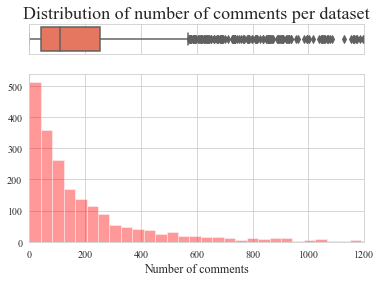

In [34]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
sns.boxplot(df["comments_no"], ax=ax_box, palette="Reds")
sns.distplot(df["comments_no"], ax=ax_hist, bins=500, kde=False, color="r")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of number of comments per dataset', fontsize=18)
ax_hist.set_xlabel("Number of comments", fontsize=12)
#plt.xscale('log')
plt.xlim(0, 1200)
plt.show()

f.tight_layout()
f.savefig("plots/no_of_comments.png", dpi=100)

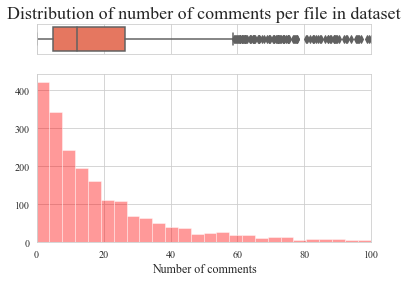

In [35]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
sns.boxplot(df["comments_no_files"], ax=ax_box, palette="Reds")
sns.distplot(df["comments_no_files"], ax=ax_hist, bins=500, kde=False, color="r")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of number of comments per file in dataset', fontsize=18)
ax_hist.set_xlabel("Number of comments", fontsize=12)
#plt.xscale('log')
plt.xlim(0, 100)
plt.show()

f.tight_layout()
f.savefig("plots/no_of_comments_file.png", dpi=100)

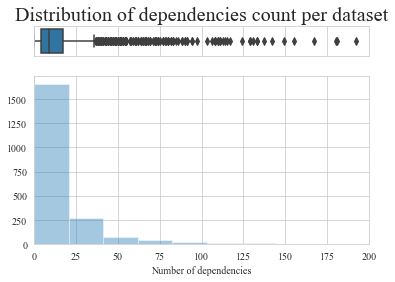

In [36]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["dependen_no"], ax=ax_box)
sns.distplot(df["dependen_no"], ax=ax_hist, kde=False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of dependencies count per dataset', fontsize=20)
ax_hist.set(xlabel="Number of dependencies")
#plt.xscale('log')
plt.xlim(0, 200)
plt.show()

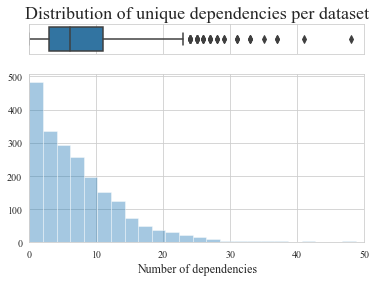

In [37]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["unique_libs_no"], ax=ax_box)
sns.distplot(df["unique_libs_no"], ax=ax_hist, bins=90, kde=False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of unique dependencies per dataset', fontsize=18)
ax_hist.set_xlabel("Number of dependencies", fontsize=12)
#plt.xscale('log')
plt.xlim(0, 50)
plt.show()

f.tight_layout()
f.savefig("plots/unique_deps.png", dpi=100)

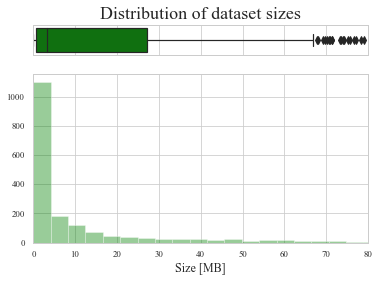

In [40]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["sizeMB"], ax=ax_box, color="g")
sns.distplot(df["sizeMB"], ax=ax_hist, bins=800, kde=False, color="g")
sns.set_context("paper")

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of dataset sizes', fontsize=18)
ax_hist.set_xlabel("Size [MB]", fontsize=12)
#plt.xscale('log')
plt.xlim(0, 80)
plt.show()

f.tight_layout()
f.savefig("plots/ds_size.pdf", dpi=100)

In [41]:
df["sizeMB"].median()

3.24

In [42]:
df["sizeMB"].mean()

92.30558584409373

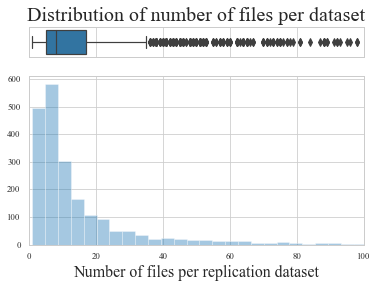

In [43]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["files_count"], ax=ax_box)
sns.distplot(df["files_count"], ax=ax_hist, bins=230, kde=False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of number of files per dataset',fontsize=20)
ax_hist.set_xlabel("Number of files per replication dataset",fontsize=16)
plt.xlim(0, 100)
plt.show()

f.tight_layout()
f.savefig("plots/files_no.png", dpi=100)

In [44]:
df.head()

,doi,list_of_all,comments_no,dependen_no,list_of_libs,total_size,sizeMB,files_count,docs,r_file,...,wflow_lib,dockerfile,space,other_code,rmd,rproj,rnw,comments_no_files,avg_file_len,unique_libs_no
0,doi:10.7910/DVN/XFQZI2,FigureA2data.dta;Readme.rtf;Condemnation.dta;C...,71,10,rms;xtable;readstata13;Matching;foreign,411332,0.41,7,1,1,...,0,0,0,1,0,0,0,10.142857,10.43,5
1,doi:10.7910/DVN/WGPDBS,campaign_effects_replication.do;replication_da...,17,1,ggplot2,12105318,12.11,3,0,1,...,0,0,0,1,0,0,0,5.666667,28.00,1
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R;tab_8_campai...,194,111,ggplot2;lm_2008;lm_2004;character.only=TRUE;li...,2959665,2.96,34,1,26,...,0,0,0,0,0,0,0,5.705882,24.03,22
3,doi:10.7910/DVN/ZWAGXZ,sponsorship_1_v3_November+6%2C+2017_12.32.csv;...,168,21,sylcount;sandwich;tidyverse;RCurl;acs;RJSONIO;...,5350420,5.35,13,1,6,...,0,0,1,0,0,0,0,12.923077,28.62,9
4,doi:10.7910/DVN/JXXNDO,wgi_CoC_2013.csv;DB14-Distance-to-Frontier-dat...,140,0,,1402185,1.40,11,1,2,...,0,0,0,0,0,0,0,12.727273,12.73,0


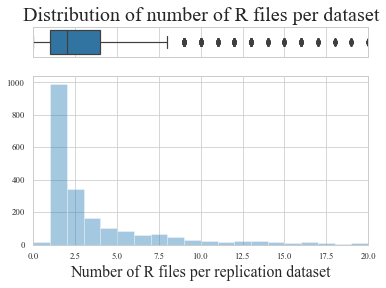

In [45]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
b = range(df["r_file"].max())
# Add a graph in each part
sns.boxplot(df["r_file"], ax=ax_box)
sns.distplot(df["r_file"], ax=ax_hist, bins=b, kde=False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of number of R files per dataset',fontsize=20)
ax_hist.set_xlabel("Number of R files per replication dataset",fontsize=16)
plt.xlim(0, 20)
plt.show()

f.tight_layout()
f.savefig("plots/r_files_no.png", dpi=100)

In [46]:
df["r_file"].median()

2.0

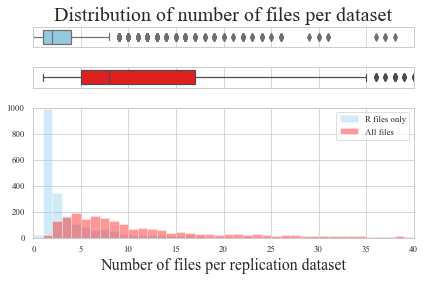

In [47]:
f, (ax_box, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.12,.12,.76)})
# figsize=(6,5),
sns.boxplot(df["r_file"], width=0.7, color="skyblue", ax=ax_box)
sns.boxplot(df["files_count"], width=0.7, color="red", ax=ax_box2)

b = range(df["r_file"].max())
sns.distplot( df["r_file"] , color="skyblue", kde=False, bins=b, label="R files only", ax=ax_hist)
sns.distplot( df["files_count"] , bins=b, color="red", kde=False, label="All files", ax=ax_hist)

ax_box.set(xlabel='')
ax_box2.set(xlabel='')
ax_box.set_title('Distribution of number of files per dataset',fontsize=20)
ax_hist.set_xlabel("Number of files per replication dataset",fontsize=16)

plt.xlim(0, 40)
plt.ylim(0, 1000)
plt.legend()

f.tight_layout()
f.savefig("plots/files_combined.png", dpi=100)

In [48]:
df["files_count"].mean()

17.529890004782402

In [49]:
df["files_count"].median()

8.0

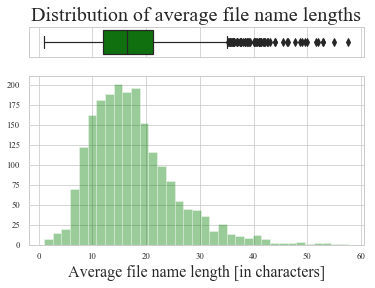

In [50]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
sns.boxplot(df["avg_file_len"], ax=ax_box, color="g")
sns.distplot(df["avg_file_len"], ax=ax_hist, color="g", bins=35, kde=False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('Distribution of average file name lengths',fontsize=20)
ax_hist.set_xlabel("Average file name length [in characters]",fontsize=16)
plt.show()
f.tight_layout()
f.savefig("plots/filename_len.png", dpi=100)

In [51]:
df["avg_file_len"].mean()

17.419215686274512

In [52]:
libs = df['list_of_libs']

In [53]:
df.head()

,doi,list_of_all,comments_no,dependen_no,list_of_libs,total_size,sizeMB,files_count,docs,r_file,...,wflow_lib,dockerfile,space,other_code,rmd,rproj,rnw,comments_no_files,avg_file_len,unique_libs_no
0,doi:10.7910/DVN/XFQZI2,FigureA2data.dta;Readme.rtf;Condemnation.dta;C...,71,10,rms;xtable;readstata13;Matching;foreign,411332,0.41,7,1,1,...,0,0,0,1,0,0,0,10.142857,10.43,5
1,doi:10.7910/DVN/WGPDBS,campaign_effects_replication.do;replication_da...,17,1,ggplot2,12105318,12.11,3,0,1,...,0,0,0,1,0,0,0,5.666667,28.00,1
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R;tab_8_campai...,194,111,ggplot2;lm_2008;lm_2004;character.only=TRUE;li...,2959665,2.96,34,1,26,...,0,0,0,0,0,0,0,5.705882,24.03,22
3,doi:10.7910/DVN/ZWAGXZ,sponsorship_1_v3_November+6%2C+2017_12.32.csv;...,168,21,sylcount;sandwich;tidyverse;RCurl;acs;RJSONIO;...,5350420,5.35,13,1,6,...,0,0,1,0,0,0,0,12.923077,28.62,9
4,doi:10.7910/DVN/JXXNDO,wgi_CoC_2013.csv;DB14-Distance-to-Frontier-dat...,140,0,,1402185,1.40,11,1,2,...,0,0,0,0,0,0,0,12.727273,12.73,0


In [54]:
libs_list = []
for l in libs:
    libs_list.extend(l.split(';'))
    
while("" in libs_list) : 
    libs_list.remove("") 

In [55]:
import collections

x=collections.Counter(libs_list)
x = x.most_common()[:50]

In [56]:
t = map(list, zip(*x))
names = t[0]
counts = t[1]

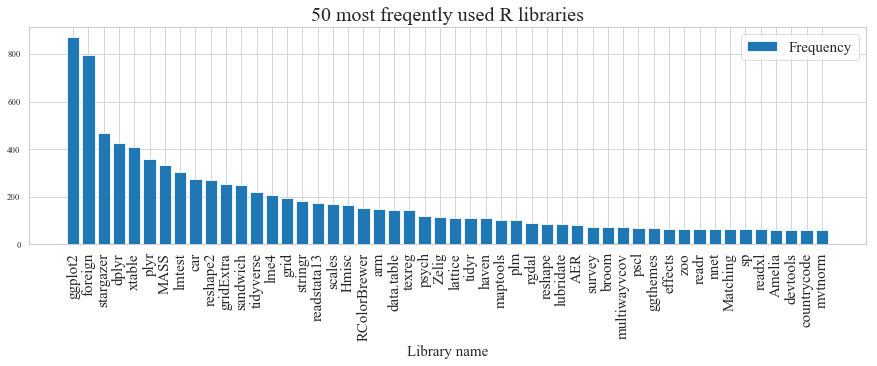

In [57]:
plt.figure(figsize=(15,4))
r = range(0, len(counts))
plt.bar(r, counts, label="Frequency")
plt.xticks(r, names, rotation=90, fontsize=15)

plt.xlabel("Library name", size=15)

plt.legend(loc='upper right',  ncol=1,prop={'size': 15})

plt.title("50 most freqently used R libraries", size=20)

plt.savefig("plots/lib_frequency.png", bbox_inches = "tight")
plt.show()

# Pies and Bars

In [58]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

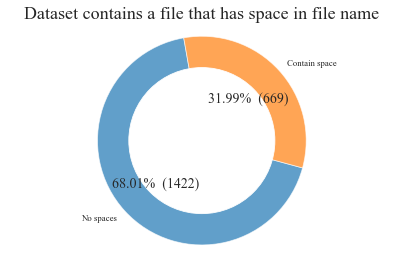

In [59]:
# Pie chart
labels = ['No spaces', 'Contain space']
sizes = [(df['space'] == 0).sum(), (df['space'] == 1).sum()]
#colors = ['#99ff99', '#ff9999']
 
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 15
ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=100,  textprops={'fontsize': 14}, wedgeprops={'alpha':0.7})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("Dataset contains a file that has space in file name", size=18)
plt.tight_layout()

plt.show()
fig.savefig("plots/space.png", dpi=100)

# Testing script

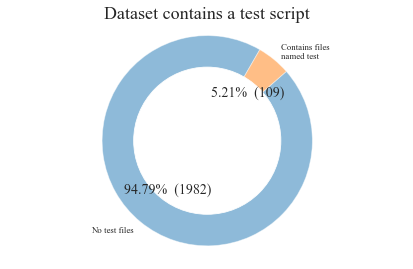

In [60]:
# Pie chart
labels = ['No test files', 'Contains files \nnamed test']
sizes = [(df['test'] == 0).sum(), (df['test'] == 1).sum()]
#colors = ['#99ff99', '#ff9999']
 
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 15
ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=60,  textprops={'fontsize': 14}, wedgeprops={'alpha':0.5})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("Dataset contains a test script", size=18)
plt.tight_layout()

plt.show()
fig.savefig("plots/test_script.png", dpi=100)

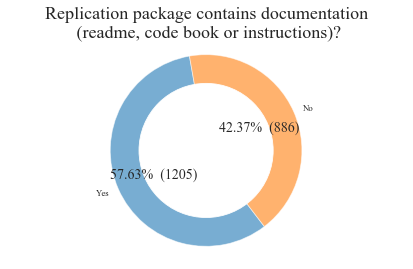

In [61]:
# Pie chart
labels = ['Yes',  'No']
sizes = [(df['docs'] == 1).sum(), (df['docs'] == 0).sum()]
 
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 15
ax1.pie(sizes, labels=labels, autopct=make_autopct(
    sizes), startangle=100,  textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("Replication package contains documentation\n (readme, code book or instructions)?", size=18)
plt.tight_layout()

plt.show()
fig.savefig("plots/docs.png", dpi=100)

# Other programming languages

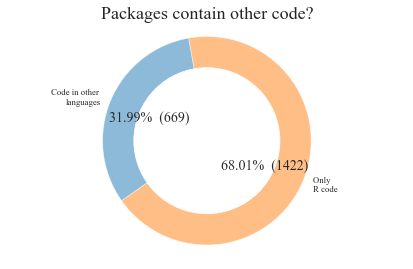

In [62]:
# Pie chart
labels = ['Code in other \nlanguages',  'Only \nR code']
sizes = [len(df)-(df['other_code'] == 0).sum(), (df['other_code'] == 0).sum()]
#colors = ['#ff9999','#99ff99']
 
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 15
ax1.pie(sizes, labels=labels, autopct=make_autopct(
    sizes), startangle=100,  textprops={'fontsize': 14}, wedgeprops={'alpha':0.5})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("Packages contain other code?", size=18)
plt.tight_layout()

plt.show()
#fig1.savefig("plots/other_code.png", dpi=100)

In [63]:
df.head()

,doi,list_of_all,comments_no,dependen_no,list_of_libs,total_size,sizeMB,files_count,docs,r_file,...,wflow_lib,dockerfile,space,other_code,rmd,rproj,rnw,comments_no_files,avg_file_len,unique_libs_no
0,doi:10.7910/DVN/XFQZI2,FigureA2data.dta;Readme.rtf;Condemnation.dta;C...,71,10,rms;xtable;readstata13;Matching;foreign,411332,0.41,7,1,1,...,0,0,0,1,0,0,0,10.142857,10.43,5
1,doi:10.7910/DVN/WGPDBS,campaign_effects_replication.do;replication_da...,17,1,ggplot2,12105318,12.11,3,0,1,...,0,0,0,1,0,0,0,5.666667,28.00,1
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R;tab_8_campai...,194,111,ggplot2;lm_2008;lm_2004;character.only=TRUE;li...,2959665,2.96,34,1,26,...,0,0,0,0,0,0,0,5.705882,24.03,22
3,doi:10.7910/DVN/ZWAGXZ,sponsorship_1_v3_November+6%2C+2017_12.32.csv;...,168,21,sylcount;sandwich;tidyverse;RCurl;acs;RJSONIO;...,5350420,5.35,13,1,6,...,0,0,1,0,0,0,0,12.923077,28.62,9
4,doi:10.7910/DVN/JXXNDO,wgi_CoC_2013.csv;DB14-Distance-to-Frontier-dat...,140,0,,1402185,1.40,11,1,2,...,0,0,0,0,0,0,0,12.727273,12.73,0


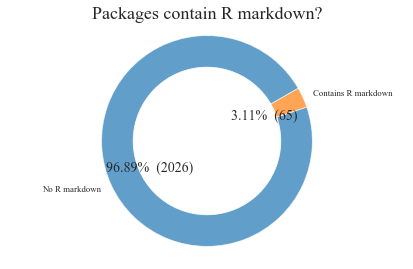

In [64]:
# Pie chart
labels = ['No R markdown',  'Contains R markdown']
sizes = [(df['rmd'] == 0).sum(), (df['rmd'] == 1).sum()]
#colors = ['#ff9999','#99ff99']
 
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 15
ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=30,  textprops={'fontsize': 14}, wedgeprops={'alpha':0.7})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("Packages contain R markdown?", size=18)
plt.tight_layout()

plt.show()
fig1.savefig("plots/rmd.png", dpi=100)

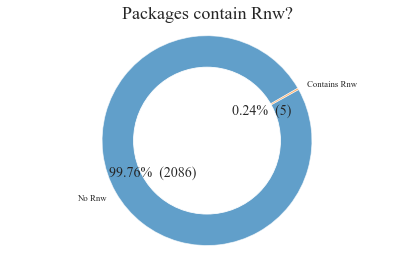

In [65]:
# Pie chart
labels = ['No Rnw',  'Contains Rnw']
sizes = [(df['rnw'] == 0).sum(), (df['rnw'] == 1).sum()]
#colors = ['#ff9999','#99ff99']
 
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 15
ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=30,  textprops={'fontsize': 14}, wedgeprops={'alpha':0.7})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("Packages contain Rnw?", size=18)
plt.tight_layout()

plt.show()
fig1.savefig("plots/rnw.png", dpi=100)

# Success rate in dataset level

In [66]:
len(df.doi.unique())

2091

In [68]:
df1 = pd.read_csv("data/aggregate_results_env.csv", index_col=0)
len(df1)

7414

In [69]:
success = len(df1[df1.result == 'success'])
total = len(df1[df1.result.notna()])
success*1./total

0.3983761840324763

## aggregate result per dataset

In [70]:
df1 = df1[df1['result'].notna()]

In [71]:
ndf = df1.groupby(['doi'], sort=False)['success'].max().reset_index()
ndf.head()

,doi,success
0,doi:10.7910/DVN/WGPDBS,1.0
1,doi:10.7910/DVN/BPON3K,1.0
2,doi:10.7910/DVN/ZWAGXZ,0.0
3,doi:10.7910/DVN/NVRBC9,1.0
4,doi:10.7910/DVN/WCTILJ,0.0


In [72]:
ndf = ndf.merge(df, on = 'doi')
ndf.head()

,doi,success,list_of_all,comments_no,dependen_no,list_of_libs,total_size,sizeMB,files_count,docs,...,wflow_lib,dockerfile,space,other_code,rmd,rproj,rnw,comments_no_files,avg_file_len,unique_libs_no
0,doi:10.7910/DVN/WGPDBS,1.0,campaign_effects_replication.do;replication_da...,17,1,ggplot2,12105318,12.11,3,0,...,0,0,0,1,0,0,0,5.666667,28.00,1
1,doi:10.7910/DVN/BPON3K,1.0,fig_10_effect_of_winning_on_gov.R;tab_8_campai...,194,111,ggplot2;lm_2008;lm_2004;character.only=TRUE;li...,2959665,2.96,34,1,...,0,0,0,0,0,0,0,5.705882,24.03,22
2,doi:10.7910/DVN/ZWAGXZ,0.0,sponsorship_1_v3_November+6%2C+2017_12.32.csv;...,168,21,sylcount;sandwich;tidyverse;RCurl;acs;RJSONIO;...,5350420,5.35,13,1,...,0,0,1,0,0,0,0,12.923077,28.62,9
3,doi:10.7910/DVN/NVRBC9,1.0,Lueders_et al_2017_driverslicenses_replication...,225,20,mapproj;maptools;dplyr;rgdal;ggrepel;ggalt;alb...,451339,0.45,3,0,...,0,0,1,0,0,0,0,75.000000,37.67,19
4,doi:10.7910/DVN/WCTILJ,0.0,Script.R;Dataset.tab,21,4,readxl;plspm,28411,0.03,2,0,...,0,0,0,0,0,0,0,10.500000,6.50,2


## aggregated no other code

In [73]:
mdf = ndf[ndf.other_code == 0]

total = len(mdf)
success = len(mdf[mdf.success == 1])
print(str(success*1./total) +" out of "+str(total))

0.453663793103 out of 928


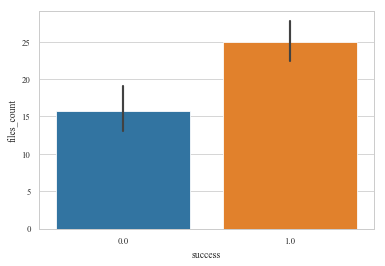

In [74]:
sns.barplot(x="success", y="files_count", data=ndf)

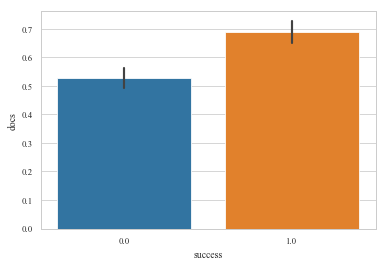

In [75]:
sns.barplot(x="success", y="docs", data=ndf)

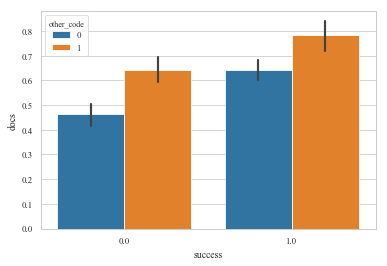

In [76]:
sns.barplot(x="success", y="docs", hue='other_code', data=ndf)

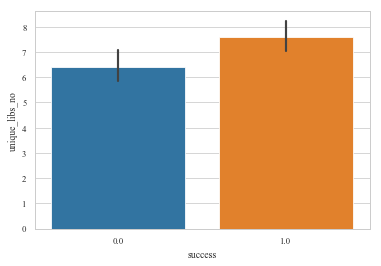

In [77]:
sns.barplot(x="success", y="unique_libs_no", data=ndf)

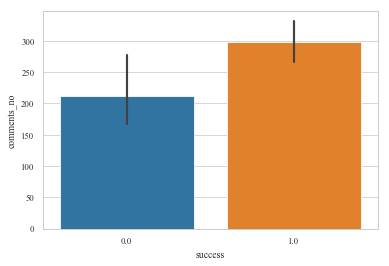

In [78]:
sns.barplot(x="success", y="comments_no", data=ndf)

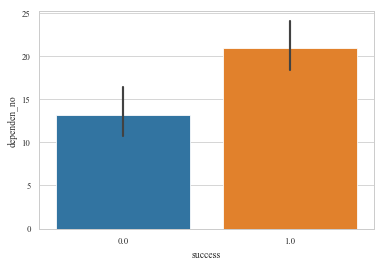

In [79]:
sns.barplot(x="success", y="dependen_no", data=ndf)

In [80]:
total = len(ndf)
success = len(ndf[ndf.success > 0])
print(str(success*1./total) +" out of "+str(total))

0.43931866572 out of 1409


## success rate when excluding datasets with other code

In [81]:
len(df1.doi.unique())

1447

In [82]:
merged = df1.merge(df, on = 'doi')

In [83]:
len(merged.doi.unique())

1409

In [84]:
mdf = merged[merged['result'].notna()]
mdf = mdf[mdf.other_code == 0]

total = len(mdf)
success = len(mdf[mdf.result == 'success'])
print(str(success*1./total) +" out of "+str(total))

0.379782521144 out of 2483


## Conclusion: success rate when excluding datasets with other code (38%) is similar to the general one (39%)